In [8]:
# ------------------------------------------------------------------
# Library
# ------------------------------------------------------------------

import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from pathlib import Path
import seaborn as sns
import json

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow import keras

import keras_tuner as kt
from keras_tuner.engine import oracle as kt_oracle
from keras_tuner import Objective

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)

In [9]:
# ------------------------------------------------------------------
# Paths  (edit these only) - Monthly Data
# ------------------------------------------------------------------
# EIA Format (https://www.eia.gov/dnav/pet/pet_pri_spt_s1_m.htm)
XLS_BRENT                = r"C:\Users\manue\Desktop\brent_europe.xls"

# GPR Format (https://www.matteoiacoviello.com/gpr.htm)
XLS_GPR                  = r"C:\Users\manue\Desktop\gpr_monthly.xls"

# Eurostat Format (https://ec.europa.eu/eurostat/databrowser/explore/all/envir?lang=en&subtheme=nrg&display=list&sort=category)
XLS_STOCK                = r"C:\Users\manue\Desktop\stock_europe.xlsx"
XLS_SUPPLY_TRANSF_CONSUM = r"C:\Users\manue\Desktop\supply_transformation_consumption_europe.xlsx"

# Producer Price Indices (Eurostat)
XLS_INDUSTRY = r"C:\Users\manue\Desktop\sts_inpp_m__custom_17578537_spreadsheet.xlsx"

# ------------------------------------------------------------------
# Convert to monthly PeriodIndex & drop NaNs
# ------------------------------------------------------------------

def to_month_period(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = df.index.to_period("M")
    return df.dropna()

# ------------------------------------------------------------------
# Brent
# ------------------------------------------------------------------

brent = (
    pd.read_excel(
        XLS_BRENT,
        sheet_name="Data 1",
        skiprows=3,
        usecols="A,C",
        names=["Date", "Brent"],
        parse_dates=["Date"],
    )
    .assign(Brent=lambda d: pd.to_numeric(d["Brent"], errors="coerce"))
    .set_index("Date")
    .sort_index()
)
brent = brent.loc[brent["Brent"].first_valid_index():]
brent = to_month_period(brent)

# ------------------------------------------------------------------
# GPR
# ------------------------------------------------------------------

gpr = (
    pd.read_excel(XLS_GPR, sheet_name="Sheet1", usecols=["month", "GPR"])
      .rename(columns={"month": "Date"})
      .assign(
          Date=lambda d: pd.to_datetime(d["Date"], dayfirst=True),
          GPR=lambda d: pd.to_numeric(d["GPR"], errors="coerce"),
      )
      .set_index("Date")
      .sort_index()
)
gpr = to_month_period(gpr)

# ------------------------------------------------------------------
# EU-27 oil stocks
# ------------------------------------------------------------------

raw_stocks        = pd.read_excel(XLS_STOCK, sheet_name="Sheet 1", header=None)
header_row_stock  = raw_stocks.index[raw_stocks.iloc[:, 0] == "TIME"][0]
df_stocks         = pd.read_excel(XLS_STOCK, sheet_name="Sheet 1", header=header_row_stock)

eu27_row_stock    = df_stocks[df_stocks.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_stock   = df_stocks.columns[1:]
eu27_values_stock = eu27_row_stock[1:].values

stocks = (
    pd.DataFrame({
        "Date":   pd.to_datetime(time_cols_stock.astype(str), format="%Y-%m", errors="coerce"),
        "Stocks": pd.to_numeric(eu27_values_stock, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
stocks = to_month_period(stocks)

# ------------------------------------------------------------------
# EU-27 supply & transformation of oil/petroleum
# ------------------------------------------------------------------
raw_sup        = pd.read_excel(XLS_SUPPLY_TRANSF_CONSUM, sheet_name="Sheet 1", header=None)
header_row_sup = raw_sup.index[raw_sup.iloc[:, 0] == "TIME"][0]
df_sup         = pd.read_excel(
    XLS_SUPPLY_TRANSF_CONSUM,
    sheet_name="Sheet 1",
    header=header_row_sup
)

eu27_row_sup   = df_sup[df_sup.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_sup  = df_sup.columns[1:]
eu27_vals_sup  = eu27_row_sup[1:].values

supply_transf = (
    pd.DataFrame({
        "Date":   pd.to_datetime(time_cols_sup.astype(str), format="%Y-%m", errors="coerce"),
        "Supply": pd.to_numeric(eu27_vals_sup, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
supply_transf = to_month_period(supply_transf)

# ------------------------------------------------------------------
# PPI
# ------------------------------------------------------------------

# Coke & refined petroleum products
raw_coke = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 1", header=None)
header_row_coke = raw_coke.index[raw_coke.iloc[:, 0] == "TIME"][0]
df_coke = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 1", header=header_row_coke)
eu27_row_coke = df_coke[df_coke.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_coke = df_coke.columns[1:]
eu27_vals_coke = eu27_row_coke[1:].values
coke_refined = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_coke.astype(str), format="%Y-%m", errors="coerce"),
        "Coke and Refined": pd.to_numeric(eu27_vals_coke, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
coke_refined = to_month_period(coke_refined)

# Chemicals & chemical products
raw_chem = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 5", header=None)
header_row_chem = raw_chem.index[raw_chem.iloc[:, 0] == "TIME"][0]
df_chem = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 5", header=header_row_chem)
eu27_row_chem = df_chem[df_chem.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_chem = df_chem.columns[1:]
eu27_vals_chem = eu27_row_chem[1:].values
chemicals = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_chem.astype(str), format="%Y-%m", errors="coerce"),
        "Chemicals": pd.to_numeric(eu27_vals_chem, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
chemicals = to_month_period(chemicals)

# Rubber & plastic products
raw_rub = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 9", header=None)
header_row_rub = raw_rub.index[raw_rub.iloc[:, 0] == "TIME"][0]
df_rub = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 9", header=header_row_rub)
eu27_row_rub = df_rub[df_rub.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_rub = df_rub.columns[1:]
eu27_vals_rub = eu27_row_rub[1:].values
rubber_plastic = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_rub.astype(str), format="%Y-%m", errors="coerce"),
        "Rubber and Plastic": pd.to_numeric(eu27_vals_rub, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
rubber_plastic = to_month_period(rubber_plastic)

# Basic metals
raw_met = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 13", header=None)
header_row_met = raw_met.index[raw_met.iloc[:, 0] == "TIME"][0]
df_met = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 13", header=header_row_met)
eu27_row_met = df_met[df_met.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_met = df_met.columns[1:]
eu27_vals_met = eu27_row_met[1:].values
basic_metals = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_met.astype(str), format="%Y-%m", errors="coerce"),
        "Basic Metals": pd.to_numeric(eu27_vals_met, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
basic_metals = to_month_period(basic_metals)

# Machinery & equipment n.e.c.
raw_mach = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 17", header=None)
header_row_mach = raw_mach.index[raw_mach.iloc[:, 0] == "TIME"][0]
df_mach = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 17", header=header_row_mach)
eu27_row_mach = df_mach[df_mach.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_mach = df_mach.columns[1:]
eu27_vals_mach = eu27_row_mach[1:].values
machinery = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_mach.astype(str), format="%Y-%m", errors="coerce"),
        "Machinery": pd.to_numeric(eu27_vals_mach, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
machinery = to_month_period(machinery)

# Motor vehicles, trailers & semi-trailers
raw_auto = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 21", header=None)
header_row_auto = raw_auto.index[raw_auto.iloc[:, 0] == "TIME"][0]
df_auto = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 21", header=header_row_auto)
eu27_row_auto = df_auto[df_auto.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_auto = df_auto.columns[1:]
eu27_vals_auto = eu27_row_auto[1:].values
automotive = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_auto.astype(str), format="%Y-%m", errors="coerce"),
        "Automotive": pd.to_numeric(eu27_vals_auto, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
automotive = to_month_period(automotive)

# Other transport equipment
raw_oth = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 25", header=None)
header_row_oth = raw_oth.index[raw_oth.iloc[:, 0] == "TIME"][0]
df_oth = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 25", header=header_row_oth)
eu27_row_oth = df_oth[df_oth.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_oth = df_oth.columns[1:]
eu27_vals_oth = eu27_row_oth[1:].values
other_transport = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_oth.astype(str), format="%Y-%m", errors="coerce"),
        "Other Transport": pd.to_numeric(eu27_vals_oth, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
other_transport = to_month_period(other_transport)
# ------------------------------------------------------------------
# Merge – keep ONLY common months, no filling
# ------------------------------------------------------------------
df_all = (
    brent
        .join(gpr, how="inner")
        .join(stocks, how="inner")
        .join(supply_transf, how="inner")
        .join(coke_refined,   how="inner")
        .join(chemicals,      how="inner")
        .join(rubber_plastic, how="inner")
        .join(basic_metals,   how="inner")
        .join(machinery,      how="inner")
        .join(automotive,     how="inner")
        .join(other_transport,how="inner")
        .dropna()
        .sort_index()
)

# ------------------------------------------------------------------
# Check for missing months inside the range
# ------------------------------------------------------------------
full_span = pd.period_range(df_all.index.min(), df_all.index.max(), freq="M")
missing   = full_span.difference(df_all.index)

print(df_all.head())
print(df_all.tail())
print("\n")
print(df_all.info())

print("\nDataset spans:")
print("Brent :", brent.index.min(), "->", brent.index.max(), f"({len(brent)} months)")
print("GPR   :", gpr.index.min(), "->", gpr.index.max(), f"({len(gpr)} months)")
print("Stocks:", stocks.index.min(), "->", stocks.index.max(), f"({len(stocks)} months)")
print("Supply:", supply_transf.index.min(), "->", supply_transf.index.max(), f"({len(supply_transf)} months)")
print("Coke  :", coke_refined.index.min(), "->", coke_refined.index.max(), f"({len(coke_refined)} months)")
print("Chem  :", chemicals.index.min(), "->", chemicals.index.max(), f"({len(chemicals)} months)")
print("RubPl :", rubber_plastic.index.min(), "->", rubber_plastic.index.max(), f"({len(rubber_plastic)} months)")
print("Metals:", basic_metals.index.min(), "->", basic_metals.index.max(), f"({len(basic_metals)} months)")
print("Mach  :", machinery.index.min(), "->", machinery.index.max(), f"({len(machinery)} months)")
print("Auto  :", automotive.index.min(), "->", automotive.index.max(), f"({len(automotive)} months)")
print("O-Trans:", other_transport.index.min(), "->", other_transport.index.max(), f"({len(other_transport)} months)")
print("Common:", df_all.index.min(), "->", df_all.index.max(), f"({len(df_all)} months)")

print("\nMissing months *within* common span:", len(missing))
if len(missing):
    print(missing.to_timestamp())


C:\Users\manue\PycharmProjects\PythonProject\.venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\manue\PycharmProjects\PythonProject\.venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


          Brent        GPR    Stocks   Supply  Coke and Refined  Chemicals  \
Date                                                                         
2013-01  112.96  90.657494  155831.0  38139.0             113.3       92.6   
2013-02  116.05  81.590332  158434.0  36042.0             117.0       92.7   
2013-03  108.47  75.896721  159577.0  39301.0             113.5       93.1   
2013-04  102.25  95.107872  158948.0  40293.0             109.3       92.3   
2013-05  102.56  83.717316  157220.0  40830.0             108.4       91.5   

         Rubber and Plastic  Basic Metals  Machinery  Automotive  \
Date                                                               
2013-01                93.8          79.0       91.3        94.5   
2013-02                93.9          78.9       91.3        94.3   
2013-03                94.0          78.5       91.4        94.5   
2013-04                93.9          77.6       91.5        94.4   
2013-05                93.8          77.2    

In [10]:
# =============================================================================
#  PRE‑PROCESSING FOR MONTHLY BRENT MULTIVARIATE DATA
# -----------------------------------------------------------------------------
#  * Builds chronological train, validation and test blocks.
#  * Standardises predictors and the target using statistics from the
#    training block only (prevents data leakage).
#  * Generates overlapping (seq_in, seq_out) windows for a sequence‑to‑sequence
#    LSTM.  I followed the approach described here:
#    https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting/
# =============================================================================

# ------------------------------------------------------------------
# MY SETTINGS
# ------------------------------------------------------------------

SEQ_IN   = 24   # months fed into the network; raise for more context
SEQ_OUT  = 3    # months to forecast; larger values increase difficulty
VAL_SIZE = 24   # validation window length (used for early stopping)
TEST_SIZE = 3   # final hold‑out period, never touched during training
SEED     = 42   # global random seed for full reproducibility

# ----------------------------------------------------------------------------

# ------------------------------------------------------------------
# 0. Deterministic behaviour
# ------------------------------------------------------------------

tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ------------------------------------------------------------------
# 1. Build model DataFrame
# ------------------------------------------------------------------

features = ["Brent", "GPR", "Supply", "Stocks"]  # predictor columns
target   = "Brent"

df_model = df_all.copy()

# Add a one‑month lag of the target (helps the network learn residuals)
df_model["Brent_lag1"] = df_model[target].shift(1)
features += ["Brent_lag1"]

# First row now contains NaN in Brent_lag1, so drop it
df_model = df_model.dropna()

# ------------------------------------------------------------------
# 2. Chronological split into train, val, test
# ------------------------------------------------------------------

def chronological_split(df, val_size, test_size):

    train_end = len(df) - (test_size + val_size)
    val_end   = len(df) - test_size
    return df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

train_df, val_df, test_df = chronological_split(df_model, VAL_SIZE, TEST_SIZE)

# ------------------------------------------------------------------
# 3. Scale predictors and target (fit only on training data)
# ------------------------------------------------------------------

scaler_X, scaler_y = StandardScaler(), StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[[target]])

X_val   = scaler_X.transform(val_df[features])
y_val   = scaler_y.transform(val_df[[target]])

# ------------------------------------------------------------------
# 4. Turn tabular data into 3‑D windows
# ------------------------------------------------------------------

def make_windows(X, y, n_in=12, n_out=3):

    Xs, ys = [], []
    for i in range(len(X) - n_in - n_out + 1):
        Xs.append(X[i : i + n_in])
        ys.append(y[i + n_in : i + n_in + n_out, 0])
    return np.asarray(Xs), np.asarray(ys)

# Create training sequences
X_tr_seq, y_tr_seq = make_windows(X_train, y_train, SEQ_IN, SEQ_OUT)

# For validation, include the tail of the training block so that windows have the correct context at the boundary
X_val_ctx = np.vstack([X_train[-(SEQ_IN + VAL_SIZE - 1):], X_val])
y_val_ctx = np.vstack([y_train[-(SEQ_IN + VAL_SIZE - 1):], y_val])
X_val_seq, y_val_seq = make_windows(X_val_ctx, y_val_ctx, SEQ_IN, SEQ_OUT)

# ------------------------------------------------------------------
# 5.  Checks
# ------------------------------------------------------------------

print(f"Features used: {features}")
print(f"Train samples (windows): {X_tr_seq.shape[0]}")
print(f"Validation samples     : {X_val_seq.shape[0]}")
print(f"Test months (held‑out) : {TEST_SIZE}")


Features used: ['Brent', 'GPR', 'Supply', 'Stocks', 'Brent_lag1']
Train samples (windows): 92
Validation samples     : 45
Test months (held‑out) : 3


Plot saved to C:\Users\manue\Desktop\series_overview_unscaled_events.png


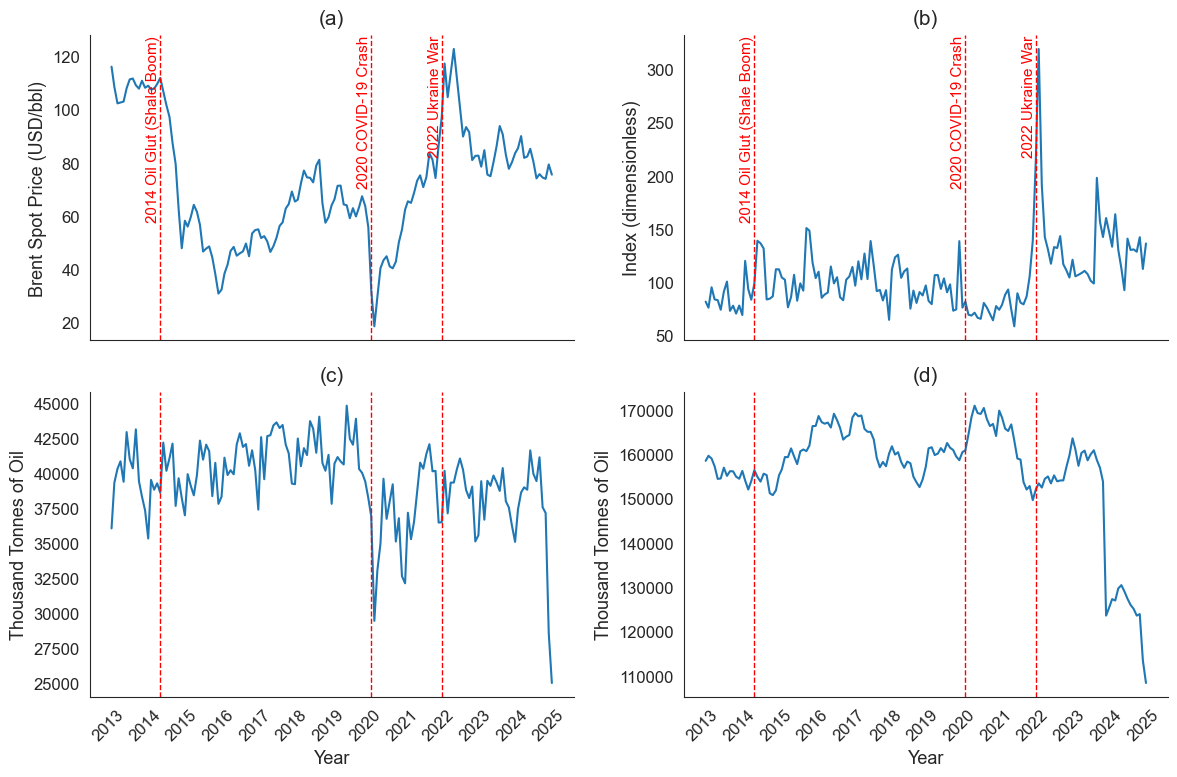

In [11]:
# ------------------------------------------------------------------
# Feature Plots
# ------------------------------------------------------------------

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Series
plot_cols  = ["Brent", "GPR", "Supply", "Stocks"]
title_map  = {"Brent": "(a)", "GPR": "(b)", "Supply": "(c)", "Stocks": "(d)"}
ylabel_map = {
    "Brent":  "Brent Spot Price (USD/bbl)",
    "GPR":    "Index (dimensionless)",
    "Supply": "Thousand Tonnes of Oil",
    "Stocks": "Thousand Tonnes of Oil",
}

# Events
events = [
    ("1973-10-01", "1973 Oil Embargo"),
    ("1979-01-01", "1979 Iranian Revolution"),
    ("1981-08-01", "1981 Volcker Recession"),
    ("1986-03-01", "1986 Oil Price Collapse"),
    ("1990-08-01", "1990 Gulf War"),
    ("1997-07-01", "1997 Asian Financial Crisis"),
    ("2004-01-01", "2004 China Demand Surge"),
    ("2008-09-01", "2008 Financial Crisis"),
    ("2010-01-01", "2010 Arab Spring"),
    ("2014-06-01", "2014 Oil Glut (Shale Boom)"),
    ("2020-03-01", "2020 COVID-19 Crash"),
    ("2022-02-01", "2022 Ukraine War"),
]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

month_fmt = mdates.DateFormatter("%Y")

data_start = df_model.index.to_timestamp().min()
data_end   = df_model.index.to_timestamp().max()

for ax, col in zip(axes, plot_cols):
    ax.plot(df_model.index.to_timestamp(), df_model[col], linewidth=1.5)

    for date_str, label in events:
        dt = pd.to_datetime(date_str)

        # skip events outside the data
        if dt < data_start or dt > data_end:
            continue

        ax.axvline(dt, color="red", linestyle="--", linewidth=1)

        if col in ("Brent", "GPR"):
            ax.text(
                dt,
                ax.get_ylim()[1],
                label,
                rotation=90,
                rotation_mode="anchor",
                color="red",
                fontsize=11,
                ha="right",
                va="bottom",
            )

    # axes
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(month_fmt)
    ax.tick_params(axis="x", labelrotation=45, labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    ax.set_title(title_map[col], fontsize=15, pad=8)

    # x-axis label only for panels (c) and (d)
    if col in ("Supply", "Stocks"):
        ax.set_xlabel("Year", fontsize=13)

    ax.set_ylabel(ylabel_map[col], fontsize=13)


    sns.despine(ax=ax)

plt.tight_layout()

# Save
desktop_path = os.path.join(
    os.path.expanduser("~"), "Desktop", "series_overview_unscaled_events.png"
)
plt.savefig(desktop_path, dpi=300)
print(f"Plot saved to {desktop_path}")

plt.show()


Plot saved to C:\Users\manue\Desktop\std_scaled_series_overview_clean.png


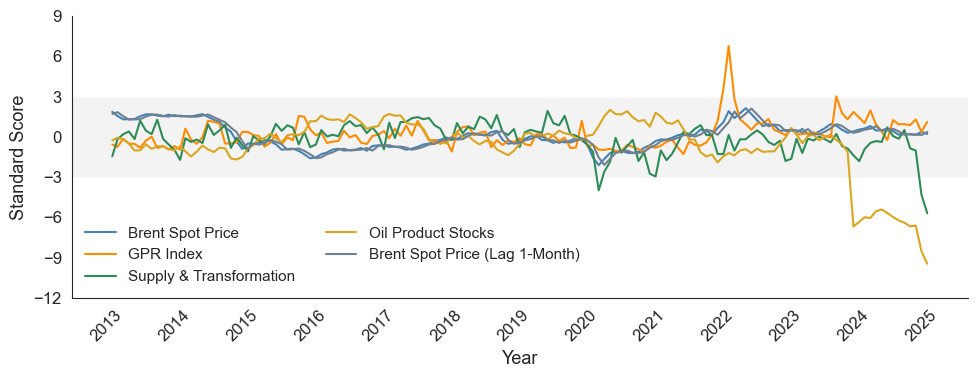

In [12]:
# ------------------------------------------------------------------
# STYLE
# ------------------------------------------------------------------


# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Series
plot_cols = ["Brent", "GPR", "Supply", "Stocks", "Brent_lag1"]

df_scaled = df_model.copy()
df_scaled[plot_cols] = scaler_X.transform(df_model[plot_cols])

label_map = {
    "Brent":       "Brent Spot Price",
    "GPR":         "GPR Index",
    "Supply":      "Supply & Transformation",
    "Stocks":      "Oil Product Stocks",
    "Brent_lag1":  "Brent Spot Price (Lag 1-Month)",
}

color_map = {
    "Brent":      "steelblue",
    "GPR":        "darkorange",
    "Supply":     "seagreen",
    "Stocks":     "goldenrod",
    "Brent_lag1": "slategray",
}

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# Grey band 3
ax.axhspan(-3, 3, facecolor="lightgray", alpha=0.25, zorder=0)

# Scaled series
for col in plot_cols:
    ax.plot(
        df_scaled.index.to_timestamp(),
        df_scaled[col],
        label=label_map[col],
        linewidth=1.5,
        color=color_map[col],
    )

# Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=45, labelsize=12)

# Y-ticks every 3 units
ymin, ymax = ax.get_ylim()
tick_start = 3 * np.floor(ymin / 3)
tick_end   = 3 * np.ceil(ymax / 3)
ax.set_yticks(np.arange(tick_start, tick_end + 3, 3))
ax.tick_params(axis="y", labelsize=12)

ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Standard Score", fontsize=13)

ax.legend(loc="lower left", ncol=2, fontsize=11, frameon=False)
sns.despine(ax=ax)
plt.tight_layout()

# Save
desktop_path = os.path.join(
    os.path.expanduser("~"), "Desktop", "std_scaled_series_overview_clean.png"
)
plt.savefig(desktop_path, dpi=300)
print(f"Plot saved to {desktop_path}")

plt.show()


Trial 90 Complete [00h 00m 07s]
val_mae: 0.5542341470718384

Best val_mae So Far: 0.22162432968616486
Total elapsed time: 00h 04m 46s

Best hyper‑parameters found: {'units_l1': 32, 'use_l2': False, 'dropout': 0.2, 'l2_reg': 0.0002504581124268098, 'lr': 0.0009230048799887741, 'units_l2': 16, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0070'}
Hypertuned model trained for 33 epochs.

[VAL] LSTM  MAE :   5.53 USD/bbl
[VAL] LSTM  RMSE:   8.11 USD/bbl
[VAL] LSTM  MAPE:   6.38 %
[VAL] Persist MAE :   9.82 USD/bbl
[VAL] Persist RMSE:  10.89 USD/bbl
[VAL] Persist MAPE:  12.40 %
-> LSTM beats persistence on validation ✅

[ALIGN] Tail check – true vs pred: [89.76 93.33 91.42] [96.89675 91.22818 89.30061]

[TEST] LSTM  MAE (3-month):   1.26 USD/bbl
[TEST] LSTM  RMSE:                    1.57 USD/bbl
[TEST] LSTM  MAPE:                    1.63 %
[TEST] Persist MAE :                  2.17 USD/bbl
[TEST] Persist RMSE:                  2.92 USD

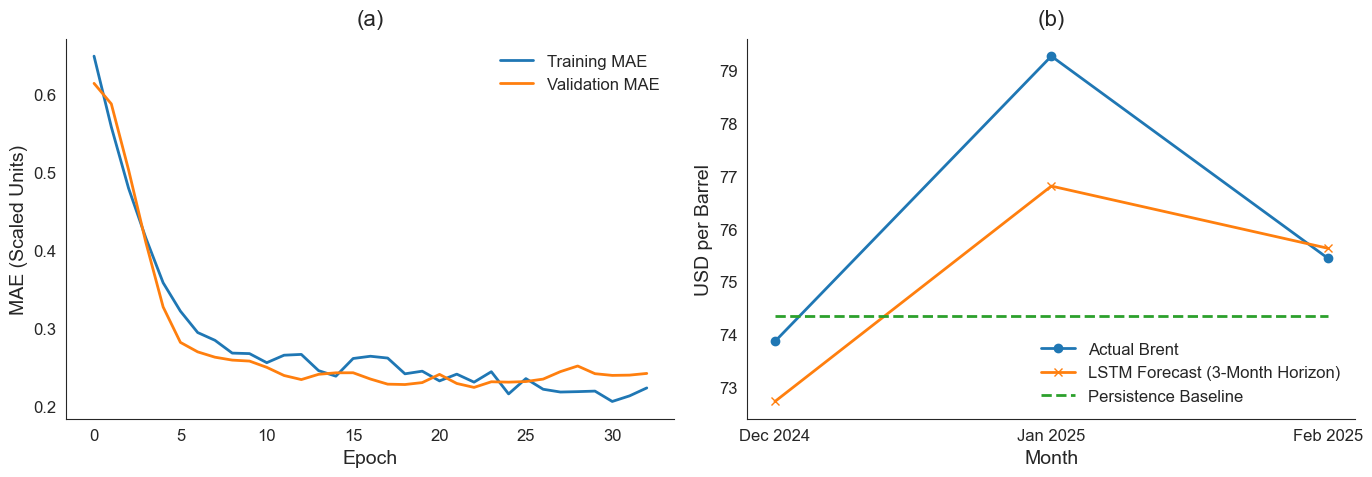


Permutation importance (MAE increase when shuffled, validation slice):
               Brent:   2.62
                 GPR:   2.43
              Stocks:   1.74
              Supply:   0.38
          Brent_lag1:  -0.00


In [13]:
# =============================================================================
#  Uni-directional LSTM for Brent: multivariate, 3‑month‑ahead forecast
# -----------------------------------------------------------------------------
#  * Section 1  : Baseline run with fixed hyper-parameters.
#  * Section 2b : Hyperband search, then full re‑train using the best set.
#  * Sections 3‑7: Forecasts, plots, and a quick permutation-importance check.
#  * Useful references
#        Keras LSTM layer   https://keras.io/api/layers/recurrent_layers/lstm/
#        Keras Tuner guide  https://www.tensorflow.org/tutorials/keras/keras_tuner
#        Reproducibility FAQ https://keras.io/getting_started/faq/
# =============================================================================

# ----------------------------------------------------------------------------
#  USER SETTINGS
# ----------------------------------------------------------------------------

# Baseline (single run, no tuning)
UNITS_L1       = 64          # higher value = captures longer patterns, risk of over‑fit
UNITS_L2       = 32          # set to 0 to drop the second LSTM layer
DROPOUT_RATE   = 0.25        # mid‑range dropout for the first shot
L2_REG         = 1e-4        # L2 weight decay to help generalisation
EPOCHS         = 300         # early stopping will quit sooner if it can
BATCH_SIZE     = 8           # reduce if the GPU complains
SEED           = 42          # global RNG seed

# ------------------------------------------------------------------
# Bounds for the KerasTuner sweep (used in Section 2b)
# ------------------------------------------------------------------

# Layer widths
MIN_UNITS_L1   = 32
MAX_UNITS_L1   = 96          # upper limit keeps the model sensible for 146 rows
STEP_UNITS_L1  = 32

ALLOW_L2_LAYER = True
MIN_UNITS_L2   = 16
MAX_UNITS_L2   = 48
STEP_UNITS_L2  = 16

# ------------------------------------------------------------------
# Regularisation and optimiser
# ------------------------------------------------------------------

MIN_DROPOUT    = 0.10        # some dropout
MAX_DROPOUT    = 0.30
DROPOUT_STEP   = 0.05

MIN_L2_REG     = 1e-4
MAX_L2_REG     = 1e-3

MIN_LR         = 1e-4
MAX_LR         = 1e-3        # lower cap keeps training stable

# ------------------------------------------------------------------
# Tuner controller
# ------------------------------------------------------------------

TUNER_OBJECTIVE   = "val_mae"  # minimise validation MAE
MAX_EPOCHS_TUNE   = 50
HYPERBAND_FACTOR  = 3
PROJECT_DIR       = "kt_brent"

# ------------------------------------------------------------------
# EarlyStopping settings
# ------------------------------------------------------------------

EARLYSTOP_MONITOR_BASE   = "val_mae"
EARLYSTOP_PATIENCE_BASE  = 10

EARLYSTOP_MONITOR_TUNE   = "val_mae"
EARLYSTOP_PATIENCE_TUNE  = 10

# ------------------------------------------------------------------
# Permutation
# ------------------------------------------------------------------

N_REPEATS = 50          # set to 0 to skip, 50 gives stable averages

# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# 0.  Make results deterministic
# ----------------------------------------------------------------------------
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# ----------------------------------------------------------------------------
# 1.  Build the baseline LSTM model
# ----------------------------------------------------------------------------
baseline_layers = [
    layers.LSTM(
        UNITS_L1,
        return_sequences=(UNITS_L2 > 0),
        activation="tanh",
        kernel_regularizer=regularizers.l2(L2_REG),
    ),
    layers.Dropout(DROPOUT_RATE),
]
if UNITS_L2 > 0:
    baseline_layers += [
        layers.LSTM(
            UNITS_L2,
            activation="tanh",
            kernel_regularizer=regularizers.l2(L2_REG),
        ),
        layers.Dropout(DROPOUT_RATE),
    ]
baseline_layers += [
    layers.Dense(32, activation="relu"),
    layers.Dense(SEQ_OUT)
]

model = models.Sequential(baseline_layers)
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

# ----------------------------------------------------------------------------
# 2.  Train baseline with EarlyStopping
# ----------------------------------------------------------------------------
callback_es = tf.keras.callbacks.EarlyStopping(
    patience=EARLYSTOP_PATIENCE_BASE,
    restore_best_weights=True,
    monitor=EARLYSTOP_MONITOR_BASE,
)

history = model.fit(
    X_tr_seq,
    y_tr_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[callback_es],
)

print(f"Baseline training stopped after {len(history.history['mae'])} epochs.")


# ----------------------------------------------------------------------------
# 2b.  Hyperparameter search (Hyperband)
# ----------------------------------------------------------------------------
def build_model(hp: kt.HyperParameters) -> tf.keras.Model:
    """Create a fresh LSTM with hyperparameters from hp."""
    # layer widths
    units_l1 = hp.Int("units_l1", MIN_UNITS_L1, MAX_UNITS_L1, STEP_UNITS_L1)
    use_l2   = hp.Boolean("use_l2") if ALLOW_L2_LAYER else False
    units_l2 = (
        hp.Int("units_l2", MIN_UNITS_L2, MAX_UNITS_L2, STEP_UNITS_L2)
        if use_l2 else 0
    )

    # regularisation and optimiser
    dropout = hp.Float("dropout", MIN_DROPOUT, MAX_DROPOUT, DROPOUT_STEP)
    l2_reg  = hp.Float("l2_reg", MIN_L2_REG, MAX_L2_REG, sampling="log")
    lr      = hp.Float("lr",     MIN_LR,     MAX_LR,     sampling="log")

    # model body
    seq = [
        layers.LSTM(
            units_l1,
            return_sequences=(units_l2 > 0),
            activation="tanh",
            kernel_regularizer=regularizers.l2(l2_reg),
        ),
        layers.Dropout(dropout),
    ]
    if units_l2 > 0:
        seq += [
            layers.LSTM(
                units_l2,
                activation="tanh",
                kernel_regularizer=regularizers.l2(l2_reg),
            ),
            layers.Dropout(dropout),
        ]
    seq += [
        layers.Dense(32, activation="relu"),
        layers.Dense(SEQ_OUT)
    ]

    m = models.Sequential(seq)
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
    )
    return m


tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective(TUNER_OBJECTIVE, direction="min"),
    max_epochs=MAX_EPOCHS_TUNE,
    factor=HYPERBAND_FACTOR,
    directory=PROJECT_DIR,
    project_name="uni_lstm_multistep",
    seed=SEED,
    overwrite=True,
)

callback_es_tune = tf.keras.callbacks.EarlyStopping(
    patience=EARLYSTOP_PATIENCE_TUNE,
    restore_best_weights=True,
    monitor=EARLYSTOP_MONITOR_TUNE,
)

tuner.search(
    X_tr_seq,
    y_tr_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=BATCH_SIZE,
    callbacks=[callback_es_tune],
    verbose=1,
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest hyper‑parameters found:", best_hp.values)

#  Rebuild and train the best model
model = tuner.hypermodel.build(best_hp)
history = model.fit(
    X_tr_seq,
    y_tr_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=MAX_EPOCHS_TUNE,
    batch_size=BATCH_SIZE,
    callbacks=[callback_es_tune],
    verbose=0,
)
print(f"Hypertuned model trained for {len(history.history['mae'])} epochs.")

# ----------------------------------------------------------------------------
# 3. Extra metrics
# ----------------------------------------------------------------------------

def fmt(num, unit="USD/bbl"):
    return f"{num:6.2f} {unit}"

# ----------------------------------------------------------------------------
# 3a. Validation diagnostics
# ----------------------------------------------------------------------------
val_pred = scaler_y.inverse_transform(
    model.predict(X_val_seq, verbose=0).reshape(-1, 1)
).flatten()
val_true = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1)).flatten()

val_mae  = mean_absolute_error(val_true, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))          # 🔧
val_mape = mean_absolute_percentage_error(val_true, val_pred) * 100

print(f"\n[VAL] LSTM  MAE : {fmt(val_mae)}")
print(f"[VAL] LSTM  RMSE: {fmt(val_rmse)}")
print(f"[VAL] LSTM  MAPE: {val_mape:6.2f} %")

val_persist = np.repeat(train_df[target].iloc[-1], len(val_df))
val_mae_p   = mean_absolute_error(val_df[target].values, val_persist)
val_rmse_p  = np.sqrt(mean_squared_error(val_df[target].values, val_persist))  # 🔧
val_mape_p  = mean_absolute_percentage_error(val_df[target].values, val_persist) * 100

print(f"[VAL] Persist MAE : {fmt(val_mae_p)}")
print(f"[VAL] Persist RMSE: {fmt(val_rmse_p)}")
print(f"[VAL] Persist MAPE: {val_mape_p:6.2f} %")

print("-> LSTM beats persistence on validation ✅"
      if val_mae < val_mae_p else
      "-> LSTM fails to beat persistence on validation ❌")

# ----------------------------------------------------------------------------
# 3b. Alignment sanity check
# ----------------------------------------------------------------------------
tail_X      = X_tr_seq[-1:]
tail_y_true = scaler_y.inverse_transform(y_tr_seq[-1:].reshape(-1, 1)).flatten()
tail_pred   = scaler_y.inverse_transform(
                model.predict(tail_X, verbose=0).reshape(-1, 1)
             ).flatten()
print("\n[ALIGN] Tail check – true vs pred:", tail_y_true, tail_pred)

# ----------------------------------------------------------------------------
# 4. Test-set forecast
# ----------------------------------------------------------------------------
last_window = df_model.iloc[len(df_model)-TEST_SIZE-SEQ_IN : len(df_model)-TEST_SIZE][features]
pred        = scaler_y.inverse_transform(
                model.predict(scaler_X.transform(last_window)[np.newaxis, ...],
                              verbose=0).reshape(-1, 1)
             ).flatten()
actual = test_df[target].values

test_mae  = mean_absolute_error(actual, pred)
test_rmse = np.sqrt(mean_squared_error(actual, pred))
test_mape = mean_absolute_percentage_error(actual, pred) * 100

print(f"\n[TEST] LSTM  MAE ({SEQ_OUT}-month): {fmt(test_mae)}")
print(f"[TEST] LSTM  RMSE:                  {fmt(test_rmse)}")
print(f"[TEST] LSTM  MAPE:                  {test_mape:6.2f} %")

persistence_pred = np.repeat(df_model[target].iloc[len(df_model)-TEST_SIZE-1],
                             TEST_SIZE)
baseline_mae  = mean_absolute_error(actual, persistence_pred)
baseline_rmse = np.sqrt(mean_squared_error(actual, persistence_pred))
baseline_mape = mean_absolute_percentage_error(actual, persistence_pred) * 100

print(f"[TEST] Persist MAE :                {fmt(baseline_mae)}")
print(f"[TEST] Persist RMSE:                {fmt(baseline_rmse)}")
print(f"[TEST] Persist MAPE:                {baseline_mape:6.2f} %")

print("-> LSTM beats persistence on *test* ✅"
      if test_mae <= baseline_mae else
      "-> LSTM fails on unseen data ❌")
# ----------------------------------------------------------------------------
# 4b. Rolling one-step forecasts on train+val (diagnostic)
# ----------------------------------------------------------------------------
def rolling_one_step_lstm(model, df, seq_in, feat_cols, scaler_X, scaler_y):
    """
    Slide a seq_in-month window through df and predict the next month
    at each position. Returns a Series of forecasts in USD/bbl.
    """
    preds = {}
    for anchor in range(seq_in, len(df)):                 # start after 1st window
        ctx   = df.iloc[anchor-seq_in:anchor][feat_cols]
        x_sc  = scaler_X.transform(ctx)
        y_sc  = model.predict(x_sc[np.newaxis, ...], verbose=0)[0, 0]
        y_inv = scaler_y.inverse_transform([[y_sc]])[0, 0]
        preds[df.index[anchor]] = y_inv
    return pd.Series(preds)

# Build forecasts and align with actual Brent
lstm_1step = rolling_one_step_lstm(
    model=model,
    df=df_model,
    seq_in=SEQ_IN,
    feat_cols=features,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
)

actual_1step = df_model["Brent"].loc[lstm_1step.index]
abs_err      = (actual_1step - lstm_1step).abs()
cum_mae      = abs_err.cumsum() / np.arange(1, len(abs_err) + 1)

print(f"Rolling 1-step MAE (train+val window): {abs_err.mean():.2f} USD/bbl")

# Save
df_out = pd.DataFrame({
    "Date": lstm_1step.index.to_timestamp(),   # PeriodIndex → Timestamp
    "Actual_Brent": actual_1step.values,
    "LSTM_1Step_Forecast": lstm_1step.values,
})

out_path = Path.home() / "Desktop" / "lstm_1step_forecast_vs_actual.xlsx"
df_out.to_excel(out_path, index=False)
print(f"Excel file saved to: {out_path}")

# -----------------------------------------------------------------------------
# 5. Plots
# -----------------------------------------------------------------------------

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,            # baseline font
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Build 1 by 2 layout
fig, (ax_lc, ax_fc) = plt.subplots(1, 2, figsize=(14, 5))

# (a) Learning curve
ax_lc.plot(history.history["mae"],     label="Training MAE",   linewidth=2)
ax_lc.plot(history.history["val_mae"], label="Validation MAE", linewidth=2)

ax_lc.set_title("(a)", fontsize=16, pad=10)
ax_lc.set_xlabel("Epoch", fontsize=14)
ax_lc.set_ylabel("MAE (Scaled Units)", fontsize=14)
ax_lc.tick_params(axis="both", labelsize=12)
ax_lc.legend(frameon=False, fontsize=12)
sns.despine(ax=ax_lc)

# (b) Forecast vs. Actual
months = test_df.index.to_timestamp()      # three Timestamp objects

ax_fc.plot(months, actual, marker="o", linewidth=2, label="Actual Brent")
ax_fc.plot(months, pred,   marker="x", linewidth=2,
           label=f"LSTM Forecast ({SEQ_OUT}-Month Horizon)")
ax_fc.plot(months, persistence_pred, linestyle="--", linewidth=2,
           label="Persistence Baseline")

# Restrict x-axis to those three dates only
ax_fc.set_xticks(months)
ax_fc.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax_fc.tick_params(axis="x", labelsize=12, rotation=0)

ax_fc.set_title("(b)", fontsize=16, pad=10)
ax_fc.set_xlabel("Month", fontsize=14)
ax_fc.set_ylabel("USD per Barrel", fontsize=14)
ax_fc.tick_params(axis="both", labelsize=12)
ax_fc.legend(frameon=False, fontsize=12)
sns.despine(ax=ax_fc)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7.  Permutation importance
#
#    https://scikit-learn.org/stable/modules/permutation_importance.html
#
#    Evaluate importance on the ENTIRE 24-month validation slice (around 35
#    windows) instead of a single window, and average across many shuffles
#    to reduce variance.
#
#    Positive delta_MAE  -> feature helps (shuffling hurts)
#    Zero / near-zero    -> neutral
#    Negative delta_MAE  -> feature appears harmful
# -----------------------------------------------------------------------------

N_REPEATS = 50          # set to 0 to skip, 50 gives stable averages

def perm_importance(
        mdl,
        X_seq,
        y_seq,
        scaler_y,
        metric=mean_absolute_error,
        n_repeats=100):

    if n_repeats == 0:
        return {}

    # Baseline MAE on the supplied slice
    base_scaled = mdl.predict(X_seq, verbose=0)
    base_pred   = scaler_y.inverse_transform(base_scaled.reshape(-1, 1)).flatten()
    y_true      = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).flatten()
    baseline_mae = metric(y_true, base_pred)

    # Permutation loop
    deltas = {}
    for col in range(X_seq.shape[2]):              # iterate over features
        jumps = []
        for _ in range(n_repeats):
            X_perm = X_seq.copy()
            np.random.shuffle(X_perm[:, :, col])   # shuffle entire column
            p_scaled = mdl.predict(X_perm, verbose=0)
            p_pred   = scaler_y.inverse_transform(p_scaled.reshape(-1, 1)).flatten()
            jumps.append(metric(y_true, p_pred) - baseline_mae)
        deltas[features[col]] = np.mean(jumps)
    return deltas


if N_REPEATS > 0:
    perm_scores = perm_importance(
        model,
        X_val_seq,          # full validation slice for stability
        y_val_seq,
        scaler_y,
        n_repeats=N_REPEATS
    )

    print("\nPermutation importance (MAE increase when shuffled, validation slice):")
    for feat, delta in sorted(perm_scores.items(), key=lambda kv: -kv[1]):
        print(f"{feat:>20}: {delta:6.2f}")

In [14]:
# -------------------------------------------------
# Save 1-step LSTM forecasts  (train + val period only)
# -------------------------------------------------
from pathlib import Path
import pandas as pd

# last in-sample month = final row before the TEST_SIZE hold-out
cutoff_date = df_model.index[-TEST_SIZE - 1]

# slice forecasts and actuals up to the cut-off
lstm_trim   = lstm_1step.loc[:cutoff_date]
actual_trim = actual_1step.loc[:cutoff_date]

# convert PeriodIndex to Timestamp
date_col = (lstm_trim.index.to_timestamp()
            if isinstance(lstm_trim.index, pd.PeriodIndex)
            else lstm_trim.index)

df_out = pd.DataFrame({
    "Date": date_col,
    "Actual_Brent": actual_trim.values,
    "LSTM_1Step_Forecast": lstm_trim.values,
})

out_path = Path.home() / "Desktop" / "lstm_1step_forecast_vs_actual.xlsx"
df_out.to_excel(out_path, index=False)
print(f"Excel file saved to: {out_path}")


Excel file saved to: C:\Users\manue\Desktop\lstm_1step_forecast_vs_actual.xlsx


Learning-curve figure saved to: C:\Users\manue\Desktop\lstm_learning_curve_gap.png


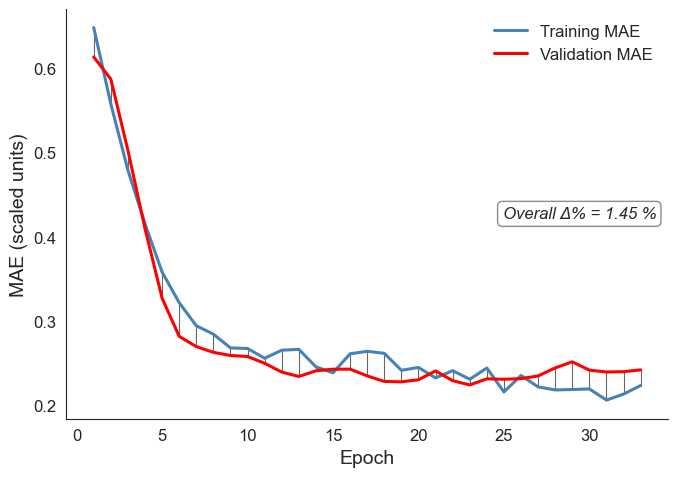

In [15]:
# -----------------------------------------------------------------------------
# Learning-Curve Plot
# -----------------------------------------------------------------------------


# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")


# Data
train_mae = np.array(history.history["mae"])
val_mae   = np.array(history.history["val_mae"])
epochs    = np.arange(1, len(train_mae) + 1)

# Relative bias of means  (always positive for display)
pct_gap_overall = abs((val_mae.mean() - train_mae.mean()) / train_mae.mean() * 100)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# thin gap connectors
for x, y_tr, y_val in zip(epochs, train_mae, val_mae):
    ax.vlines(x, y_tr, y_val, color="black", lw=0.8, alpha=0.6, zorder=0)

# learning curves
ax.plot(epochs, train_mae, label="Training MAE",   lw=2.2, color="steelblue")
ax.plot(epochs, val_mae,   label="Validation MAE", lw=2.2, color="red")

# middle-right error text
ax.text(
    0.98, 0.50,
    f"Overall Δ% = {pct_gap_overall:.2f} %",
    transform=ax.transAxes,
    ha="right", va="center",
    fontsize=12, fontstyle="italic",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
)

# Axes
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("MAE (scaled units)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.legend(frameon=False, fontsize=12)
sns.despine(ax=ax)
plt.tight_layout()

# Save
out_path = Path.home() / "Desktop" / "lstm_learning_curve_gap.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Learning-curve figure saved to: {out_path}")

plt.show()


In [16]:
# -------------------------------------------------
# Save best hyper-params
# -------------------------------------------------
best_params_path = os.path.join(os.path.expanduser("~"),
                                "Desktop", "brent_best_hyperparams.json")
with open(best_params_path, "w") as fp:
    json.dump(best_hp.values, fp, indent=2)

def epochs_in_trial(tr):

    hist = tr.metrics.metrics.get("loss")
    if hist is not None and hasattr(hist, "observations"):
        return len(hist.observations)
    # Fallback: planned budget
    return int(tr.hyperparameters.values.get("tuner/epochs", 0))

trial_rows = [
    {"Trial_ID": tid, "Epochs": epochs_in_trial(tr)}
    for tid, tr in tuner.oracle.trials.items()
]

trial_df = (pd.DataFrame(trial_rows)
              .astype({"Epochs": int})
              .sort_values("Epochs", ascending=False))

total_trials      = len(trial_df)
total_epochs      = trial_df["Epochs"].sum()
best_trial        = tuner.oracle.get_best_trials(1)[0]
best_trial_id     = best_trial.trial_id
best_trial_epochs = trial_df.loc[
    trial_df["Trial_ID"] == best_trial_id, "Epochs"].iloc[0]

final_train_epochs = len(history.history["mae"])

print("\nHyperband search summary (true epochs)")
print("-" * 45)
print(f"1. Trials run (N)               : {total_trials}")
print(f"2. Total epochs across trials   : {total_epochs}")
print(f"3. Best trial ID                : {best_trial_id}")
print(f"4. Epochs in best trial         : {best_trial_epochs}")
print(f"5. Epochs in final re-training  : {final_train_epochs}")

print("\nPer-trial epoch counts (top 20):")
print(trial_df.head(20).to_string(index=False))

trial_df = pd.concat(
    [trial_df,
     pd.DataFrame([{"Trial_ID": "TOTAL", "Epochs": total_epochs}])],
    ignore_index=True)

csv_path = os.path.join(os.path.expanduser("~"),
                        "Desktop", "brent_hyperband_trials.csv")
trial_df.to_csv(csv_path, index=False)
print(f"\nTrial summary CSV saved to: {csv_path}")

# -------------------------------------------------
# Save Metrics
# -------------------------------------------------
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE"],
    "LSTM":   [test_mae, test_rmse, test_mape],
    "Baseline_Persist": [baseline_mae, baseline_rmse, baseline_mape],
})

print(f"\nTest-set error metrics ({SEQ_OUT}-month horizon):")
print(metrics_df.to_string(index=False, formatters={
    "LSTM":             "{:6.2f}".format,
    "Baseline_Persist": "{:6.2f}".format,
}))

METRICS_PATH = os.path.join(os.path.expanduser("~"),
                            "Desktop",
                            f"brent_test_metrics_{SEQ_OUT}m.csv")
metrics_df.to_csv(METRICS_PATH, index=False)
print(f"\nTest-set metrics saved to: {METRICS_PATH}")


# -------------------------------------------------
# Save Permutation Data
# -------------------------------------------------

perm_df = (
    pd.Series(perm_scores, name="Delta_MAE")       # dict → Series
      .reset_index()                               # index → column
      .rename(columns={"index": "Feature"})        # nicer header
      .sort_values("Delta_MAE", ascending=False)   # biggest impact first
)

print("\nPermutation importance (MAE ⇧ when shuffled):")
print(perm_df.to_string(index=False))

PERM_PATH = os.path.join(os.path.expanduser("~"),
                         "Desktop",
                         "brent_perm_importance.csv")

perm_df.to_csv(PERM_PATH, index=False)
print(f"\nPermutation-importance table saved to: {PERM_PATH}")

# -------------------------------------------------
# Save Forecast Data
# -------------------------------------------------

plot_data = pd.DataFrame({
    "Month":                months,          # Timestamp index from the plot
    "Actual_Brent":         actual,
    "LSTM_Forecast":        pred,
    "Persistence_Baseline": persistence_pred,
})

plot_data["Month"] = plot_data["Month"].dt.strftime("%Y-%m")

print("\nPlotted values (USD per barrel):")
print(plot_data.to_string(index=False))

csv_path = os.path.join(os.path.expanduser("~"),
                        "Desktop",
                        "brent_forecast_vs_actual.csv")
plot_data.to_csv(csv_path, index=False)
print(f"\nCoordinate table saved to: {csv_path}")


Hyperband search summary (true epochs)
---------------------------------------------
1. Trials run (N)               : 90
2. Total epochs across trials   : 1119
3. Best trial ID                : 0072
4. Epochs in best trial         : 50
5. Epochs in final re-training  : 33

Per-trial epoch counts (top 20):
Trial_ID  Epochs
    0088      50
    0089      50
    0082      50
    0083      50
    0084      50
    0085      50
    0086      50
    0087      50
    0051      50
    0050      50
    0073      50
    0072      50
    0047      17
    0046      17
    0049      17
    0048      17
    0074      17
    0078      17
    0077      17
    0080      17

Trial summary CSV saved to: C:\Users\manue\Desktop\brent_hyperband_trials.csv

Test-set error metrics (3-month horizon):
Metric   LSTM Baseline_Persist
   MAE   1.26             2.17
  RMSE   1.57             2.92
  MAPE   1.63             2.77

Test-set metrics saved to: C:\Users\manue\Desktop\brent_test_metrics_3m.csv

Permutatio

In [18]:
# =============================================================================
#   Month-by-Month Correlation of Brent Forecasts with Producer-Price Indices
# =============================================================================
#
#   Computes rolling multistep LSTM forecasts (h = 1–3 months).
#   Produces Pearson, Spearman, and Kendall correlation heat-maps
#   and prints the tables.
# =============================================================================

# ------------------------------------------------------------------
# 2. Rolling LSTM forecasts (h1–h3)
# ------------------------------------------------------------------
def rolling_multistep_forecasts(model, df, seq_in, seq_out, feat_cols):
    fc_dict = {f"Forecast_h{i+1}": {} for i in range(seq_out)}

    for anchor in range(seq_in, len(df) - seq_out + 1):
        ctx = df.iloc[anchor - seq_in : anchor][feat_cols]
        X_sc = scaler_X.transform(ctx)
        p_sc = model.predict(X_sc[np.newaxis, ...], verbose=0)[0]

        for j in range(seq_out):
            tgt_idx = df.index[anchor + j]
            p_inv   = scaler_y.inverse_transform([[p_sc[j]]])[0, 0]
            fc_dict[f"Forecast_h{j+1}"][tgt_idx] = p_inv

    return pd.DataFrame(fc_dict)

forecast_df = (
    rolling_multistep_forecasts(
        model, df_full, SEQ_IN, SEQ_OUT, features
    )
    .loc["2020-01-01":]                            # start evaluation window
)

# ------------------------------------------------------------------
# 3. Engineering PPI columns to correlate
# ------------------------------------------------------------------
ENG_COLS = [
    "Coke and Refined",
    "Chemicals",
    "Rubber and Plastic",
    "Basic Metals",
    "Machinery",
    "Automotive",
    "Other Transport",
]

eng_df     = df_full[ENG_COLS].loc[forecast_df.index]
corr_input = pd.concat([forecast_df, eng_df], axis=1).dropna()

# ------------------------------------------------------------------
# 4. Correlation tables (Pearson, Spearman, Kendall)
# ------------------------------------------------------------------
corr_methods = ["pearson", "spearman", "kendall"]
tables = {
    m: corr_input.corr(method=m)
          .loc[forecast_df.columns, ENG_COLS]      # rows = h1–h3, cols = PPIs
          .round(2)
    for m in corr_methods
}

# ------------------------------------------------------------------
# 5.  Figures
# ------------------------------------------------------------------

sns.set_style("white")
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    13,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
})

for m in corr_methods:
    tbl = tables[m]

    # Print table
    print(f"\n=== {m.capitalize()} correlation: Brent forecasts vs. engineering PPIs ===")
    print(tbl.to_string())

    # Heat-map
    n_cols = tbl.shape[1]
    fig_w  = 1.4 * n_cols                     # scale width by #columns
    plt.figure(figsize=(fig_w, 2.8))

    sns.heatmap(
        tbl,
        annot=True, fmt=".2f", linewidths=.4,
        cmap="coolwarm", center=0,
        cbar_kws={"label": "Correlation", "shrink": 0.75}
    )

    plt.title(f"{m.capitalize()} Correlations", fontsize=15, pad=6)
    plt.yticks(rotation=0)                    # keep h1–h3 horizontal
    plt.xticks(rotation=30, ha="right")       # angled PPI labels
    plt.tight_layout()

    # Save heat-map to Desktop
    out_dir = os.path.join(os.path.expanduser("~"), "Desktop")
    fname   = f"{m}_correlations.png"
    plt.savefig(os.path.join(out_dir, fname), dpi=300)
    plt.close()



=== Pearson correlation: Brent forecasts vs. engineering PPIs ===
             Coke and Refined  Chemicals  Rubber and Plastic  Basic Metals  Machinery  Automotive  Other Transport
Forecast_h1              0.91       0.87                0.70          0.93       0.46        0.46             0.46
Forecast_h2              0.89       0.87                0.71          0.93       0.47        0.47             0.46
Forecast_h3              0.88       0.85                0.68          0.93       0.40        0.41             0.40

=== Spearman correlation: Brent forecasts vs. engineering PPIs ===
             Coke and Refined  Chemicals  Rubber and Plastic  Basic Metals  Machinery  Automotive  Other Transport
Forecast_h1              0.82       0.80                0.58          0.85       0.52        0.52             0.52
Forecast_h2              0.80       0.81                0.62          0.89       0.51        0.51             0.51
Forecast_h3              0.77       0.78                0.62